# 1. Intro to Machine Learning

### Objective

* Learn the three step process for doing machine learning with 

## Typical Workflow for Beginners
* Find dataset
    * [Kaggle Datasets][1]
    * [data.world][2]
    * [data.gov][3]
    * [UCI Machine Learning Repository][10]
* Read data into Pandas
* Clean data
* Exploratory data analysis with basic statistics and visualizations
* Define Problem
* Train and Evaluate model with Scikit-Learn

### Resources

* [Hands on Machine Learning with Scikit-Learn and Tensor Flow][6], very popular book
* [Introduction to Statistical Learning][8] by Trevor Hastie and Robert Tibshirani
* Full college class on [Applied Machine Learning][7] by Andreas Mueller, core contributor to Scikit-Learn 
* Tutorial in [Jupyter Notebooks][5] from Andreas Mueller
* My article on the [new workflow from Pandas to Scikit-Learn][9]

[1]: https://www.kaggle.com/datasets
[2]: https://data.world/
[3]: https://www.data.gov/
[5]: https://github.com/amueller/scipy-2016-sklearn
[6]: https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291
[7]: http://www.cs.columbia.edu/~amueller/comsw4995s18/schedule/
[8]: http://www-bcf.usc.edu/~gareth/ISL/data.html
[9]: https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62
[10]: https://archive.ics.uci.edu/ml/index.php

# Heart Disease Dataset

We will be using a dataset on [heart disease][1] which is used in the ISLR book. Let's read it in and take a peak at the data.

[1]: https://archive.ics.uci.edu/ml/datasets/heart+Disease

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_colwidth = 200
%matplotlib inline

In [2]:
heart = pd.read_csv('../data/heart.csv')
heart.head() #predict 'disease', whether someone has heart disease

,age,sex,chest_pain,rest_bp,chol,fbs,rest_ecg,max_hr,exang,old_peak,slope,ca,thal,disease
0,63,Male,typical,145,233,1,left ventricular hypertrophy,150,0,2.3,3,0.0,fixed,0
1,67,Male,asymptomatic,160,286,0,left ventricular hypertrophy,108,1,1.5,2,3.0,normal,1
2,67,Male,asymptomatic,120,229,0,left ventricular hypertrophy,129,1,2.6,2,2.0,reversable,1
3,37,Male,nonanginal,130,250,0,normal,187,0,3.5,3,0.0,normal,0
4,41,Female,nontypical,130,204,0,left ventricular hypertrophy,172,0,1.4,1,0.0,normal,0


### Understand the columns with help from the data dictionary
Always find or create a data dictionary when beginning a project. In this instance, it is provided for you.

In [3]:
dd = pd.read_csv('../data/heart_data_dictionary.csv')
dd

,column name,description
0,age,age in years
1,sex,Male or Female
2,chest_pain,"typical, asymptomatic, nonanginal, nontypical"
3,rest_bp,resting blood pressure (in mm Hg on admission to the hospital)
4,chol,serum cholestoral in mg/dl
5,fbs,(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
6,rest_ecg,"resting electrocardiographic results (0, 1, 2)"
7,max_hr,maximum heart rate achieved
8,exang,exercise induced angina (1 = yes; 0 = no)
9,old_peak,ST depression induced by exercise relative to rest


### Examine the data types and ensure they match the data dictionary

In [4]:
heart.dtypes

age             int64
sex            object
chest_pain     object
rest_bp         int64
chol            int64
fbs             int64
rest_ecg       object
max_hr          int64
exang           int64
old_peak      float64
slope           int64
ca            float64
thal           object
disease         int64
dtype: object

In [5]:
heart.shape

(303, 14)

# Skipping EDA
We should do a through exploratory data analysis before commencing our machine learning. For these introductory notebooks, we will skip this step and jump right into machine learning.

### Use Pandas Profiling instead
As a drop-in replacement for manual EDA, we can the [pandas-profiling package][1]. Install it from your command line with `conda install pandas-profiling`. It has only one major object, `ProfileReport`. Simply pass the DataFrame to it and it will provide you with lots of basic descriptions of the dataset.

[1]: https://github.com/pandas-profiling/pandas-profiling

In [8]:
# there is a giant warning that pandas-profiling emits when imported.
# we can ignore it with the following
import warnings
warnings.filterwarnings('ignore')
import pandas_profiling as pf

pf.ProfileReport(heart)

Number of variables,14
Number of observations,303
Total Missing (%),0.1%
Total size in memory,33.2 KiB
Average record size in memory,112.3 B
Numeric,7
Categorical,4
Boolean,3
Date,0
Text (Unique),0
Rejected,0


# Identify the target variable and type of machine learning problem
Before beginning our machine learning, we need to identify our target variable (what we are trying to predict) and then decide what type of problem it is, regression or classification. 

## Predicting Heart disease
We are interested in predicting whether some one has heart disease or not, which is the last column in our DataFrame. There are two classes of disease (0 or 1) which we see from the data dictionary correspond to either no or yes. Thus, we have a **classification** problem. From the profile report, we see that 46% of the observations do have heart disease and 54% do not. 

# Minimum data preparation
It is common to have lots of data preparation, but in this notebook, we only do the minimum necessary to get scikit-learn models to work for us. Scikit-learn does not allow missing values. Let's check for them now.

In [66]:
heart.isna().sum()

age           0
sex           0
chest_pain    0
rest_bp       0
chol          0
fbs           0
rest_ecg      0
max_hr        0
exang         0
old_peak      0
slope         0
ca            0
thal          0
disease       0
dtype: int64

### Must fill missing values
We have a couple columns that are missing values. The simplest thing to do (other than dropping those rows) is to fill them continuous columns with the mean or median and categorical with the most common observation.

### Know what type of variable - Either categorical or continuous
We fill in missing values differently depending on the type of variable we have. For instance, in this case the column `ca` has numeric values but is actually a categorical. It would not make any sense to use the mean to fill in the value here. Let's use `value_counts` to find the most common number.

In [67]:
vc_ca = heart['ca'].value_counts()
vc_ca

0    180
1     65
2     38
3     20
Name: ca, dtype: int64

In [68]:
ca_fill = vc_ca.index[0]
ca_fill

0

### Do the same for `thal`

In [69]:
vc_thal = heart['thal'].value_counts()
vc_thal

normal        168
reversable    117
fixed          18
Name: thal, dtype: int64

In [70]:
thal_fill = vc_thal.index[0]
thal_fill

'normal'

### Fill the missing value with `fillna`

In [71]:
filt1 = heart['ca'].isna()
filt2 = heart['thal'].isna()
filt = filt1 | filt2
heart[filt].style.highlight_null()

,age,sex,chest_pain,rest_bp,chol,fbs,rest_ecg,max_hr,exang,old_peak,slope,ca,thal,disease


In [72]:
heart = heart.fillna({'ca': ca_fill, 'thal': thal_fill})
heart.head()

,age,sex,chest_pain,rest_bp,chol,fbs,rest_ecg,max_hr,exang,old_peak,slope,ca,thal,disease
0,63,Male,typical,145,233,1,left ventricular hypertrophy,150,0,2.3,3,0,fixed,0
1,67,Male,asymptomatic,160,286,0,left ventricular hypertrophy,108,1,1.5,2,3,normal,1
2,67,Male,asymptomatic,120,229,0,left ventricular hypertrophy,129,1,2.6,2,2,reversable,1
3,37,Male,nonanginal,130,250,0,normal,187,0,3.5,3,0,normal,0
4,41,Female,nontypical,130,204,0,left ventricular hypertrophy,172,0,1.4,1,0,normal,0


## Verify there are no missing values

In [73]:
heart.isna().sum()

age           0
sex           0
chest_pain    0
rest_bp       0
chol          0
fbs           0
rest_ecg      0
max_hr        0
exang         0
old_peak      0
slope         0
ca            0
thal          0
disease       0
dtype: int64

### Clean-up: Change data type of `ca` to int

In [74]:
heart['ca'] = heart['ca'].astype('int')
heart.dtypes

age             int64
sex            object
chest_pain     object
rest_bp         int64
chol            int64
fbs             int64
rest_ecg       object
max_hr          int64
exang           int64
old_peak      float64
slope           int64
ca              int64
thal           object
disease         int64
dtype: object

# Put data into NumPy arrays
Scikit-learn was built to integrate directly with NumPy and has traditionally (until version 0.20) had weak integration with Pandas. Eventually, all data will be taken out of Pandas DataFrame and put into a NumPy array. We do that now.

By convention, use **`X`** and **`y`** as Python variable names. Use the **`values`** attribute to get NumPy arrays.

## Begin by using a single feature
You can do machine learning with every single feature in the model, but when first beginning, it is good to keep things simple and use a single feature. We pick `max_hr`, which from the report was the only variable that was negatively correlated to heart disease.

In [75]:
X = heart['max_hr'].values
y = heart['disease'].values

### Verify we are in NumPy and output a few of the values

In [76]:
type(X)

numpy.ndarray

In [77]:
type(y) # data type: numpy array 

numpy.ndarray

In [78]:
X[:5]

array([150, 108, 129, 187, 172])

In [79]:
y[:5]

array([0, 1, 1, 0, 0])

# Ready for machine learning in 3 steps
All machine learning models in scikit-learn work use the same three-step process to train.

1. Import the model
2. Instantiate the model
3. Train the model

# Step 1: Import the model from Scikit-Learn
The scikit-learn library is structured differently than Pandas. It keeps all of its functionality tucked away in separate modules. We import the object we want by referencing the module where it is located in and directly import just that object.

### The model is a blueprint
When we import a model, we have been handed a blueprint. It is not built. We must instantiate it, create an instance of it, in order to actually construct it. This is step two.

Let's go ahead and complete step 1 by importing one of the simplest models for classification, logistic regresion.

In [80]:
from sklearn.linear_model import LogisticRegression

#### Wait, why is the word regression in the name? Isn't this classification?

# Step 2: Instantiate the estimator
To actually construct an instance of this class and built our machine learning vehicle, we must instantiate the model. We do this by executing it as if it were a function with parentheses following the name.

In [81]:
logr = LogisticRegression() 
# ceate instance and using pre-set specifications

### Insantiating with default values
Go back into the last code cell and press **shift + tab + tab** with your cursor inside the parentheses. Notice all the parameters and their default values. When we constructed our model, we used these default values to build it. All these parameters are called **hyperparameters** in machine learning. These are 'specifications' to which our model was built. We can change them or **tune** them to construct our model in a different way.

# Step 3: Train the model
To train the model, we must give it some data. Our data is stored in the `X` and `y` Numpy arrays. All scikit-learn estimators use the **`fit`** method to train the model.

In [82]:
logr.fit(X, y) # train the model: fit method

ValueError: Expected 2D array, got 1D array instead:
array=[150. 108. 129. 187. 172. 178. 160. 163. 147. 155. 148. 153. 142. 173.
 162. 174. 168. 160. 139. 171. 144. 162. 160. 173. 132. 158. 172. 114.
 171. 114. 151. 160. 158. 161. 179. 178. 120. 112. 132. 137. 114. 178.
 162. 157. 169. 165. 123. 128. 157. 152. 168. 140. 153. 188. 144. 109.
 163. 158. 152. 125. 142. 160. 131. 170. 113. 142. 155. 165. 140. 147.
 148. 163.  99. 158. 177. 151. 141. 142. 180. 111. 148. 143. 182. 150.
 172. 180. 156. 115. 160. 149. 151. 145. 146. 175. 172. 161. 142. 157.
 158. 186. 185. 174. 159. 130. 139. 156. 162. 150. 140. 140. 146. 144.
 190. 136.  97. 132. 165. 182. 132. 127. 150. 154. 143. 111. 174. 175.
 133. 126. 170. 163. 147. 154. 202. 186. 165. 161. 125. 103. 130. 166.
 164. 159. 184. 131. 154. 152. 124. 179. 170. 160. 178. 122. 160. 145.
  96. 109. 173. 171. 170. 151. 156. 162. 158. 122. 175. 168. 169. 159.
 156. 138. 112. 111. 143. 157. 132.  88. 147. 105. 162. 173. 166. 150.
 178. 145. 161. 179. 194. 120. 195. 146. 163. 122. 143. 106. 115. 125.
 131. 152. 162. 125. 159. 154. 173. 133. 161. 147. 130. 126. 155. 154.
 170. 182. 168. 165. 160. 162. 172. 152. 122. 182. 172. 167. 179.  95.
 169. 192. 143. 172. 108. 132. 169. 117. 126. 121. 163. 116. 103. 144.
 162. 162. 153. 163. 163. 145.  96.  71. 156. 118. 168. 140. 126. 105.
 105. 157. 181. 173. 142. 116. 143. 141. 149. 152. 171. 169. 125. 125.
 156. 134. 181. 150. 138. 138. 120. 125. 162. 155. 152. 152. 164. 131.
 143. 179. 130. 174. 161. 140. 146. 144. 163. 169. 150. 166. 144. 144.
 136. 182.  90. 123. 132. 141. 115. 174. 173.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# A very annoying Gotcha!
Scikit-Learn forces you to use a 2-dimensional array for your input values. When we selected one column above into our X array, it was a single dimension. 

In [83]:
X.ndim

1

In [84]:
X.shape # confirm it's 1-d

(303,)

## Use the help from the error message to put our input array in the correct shape

In [85]:
X = X.reshape(-1, 1) # force the dimension to reshape to 2-d, 
# put new # of rows and new # of columns: ex X.reshape(101,3)
X[:5]

array([[150],
       [108],
       [129],
       [187],
       [172]])

In [86]:
X.shape #2-d, one column and 303 

(303, 1)

In [87]:
X.ndim

2

# Now, we can train our model
Now that we have two-dimensional data for our input, scikit-learn will no longer complain.

In [88]:
logr.fit(X, y) # train 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Our model is ready to use!
All machine learning models are built in different ways. Different algorithms are used to train the model. The algorithms have an objective function that they use as their guide for learning. Once they have satisfied the objective function, the model is trained.

### The objective function for logistic regression
We would like to get 100% accuracy for classification problems. The algorithm that scikit-learn uses to train a logistic regression function is an iterative one (uses for-loops). During each iteration, scikit-learn will slowly change the model so that prediction gets better (it's accuracy improves). Once the accuracy ceases to improve, then scikit-learn will stop iterating and return its best fit.

### Make a prediction
All supervised learning estimators in scikit-learn have a **`predict`** method. Let's use it to make some predictions on heart disease.

### Use a max_hr that is within the range found in the dataset
It only makes sense to predict with a value that we have seen in the dataset.

In [89]:
X.min(), X.max()

(71, 202)

### Remember the gotcha
We have to pass it a 2D array, just like we did when we trained it.

In [90]:
a = np.array([100, 150, 200])
a

array([100, 150, 200])

In [91]:
a = a.reshape(-1, 1)
a

array([[100],
       [150],
       [200]])

In [92]:
logr.predict(a)

array([1, 0, 0])

## Make a prediction for all inputs
We can make predictions on all of the inputs by passing the `predict` method our input array.

In [93]:
logr.predict(X)

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,

# Find out our accuracy - 67% Not bad!
Use the `score` method, which by default, returns the accuracy for classification problems.

In [94]:
logr.score(X, y) # 67% correct

0.66996699669967

# The actual model (with parameter values) for logistic regression
The final model for logistic regression is an equation for a cumulative probability distribution function. We can get the intercept and coefficients of our model with the **`intercept_`** and **`coef_`** attributes.

In [95]:
#logr. (shift+tab) # anything with _ is estimate 

In [96]:
logr.intercept_

array([3.47208985])

In [97]:
logr.coef_

array([[-0.02468694]])

# Logistic Regression returns a probably
Although our `logr` model returned 0's and 1's above, it really is producing a probability and if this number is greater than .5 then it returns a 1 or else it returns a 0.

# See the underlying probabilities with `predict_proba`
Let's get the probabilities for all values between the min and max `max_hr`.

In [98]:
inputs = np.arange(70, 205)
inputs

array([ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204])

In [99]:
inputs = inputs.reshape(-1, 1) #reshape to 1-d

### `predict_proba` returns an array with the probabilities of being in each class for each row
Since we only have two classes, we will have two values for each row.

In [100]:
probs = logr.predict_proba(inputs)
probs[:5]
#probs[-15:].round(2) #chop of decimals

array([[0.14880508, 0.85119492],
       [0.15195916, 0.84804084],
       [0.15516792, 0.84483208],
       [0.15843177, 0.84156823],
       [0.16175113, 0.83824887]])

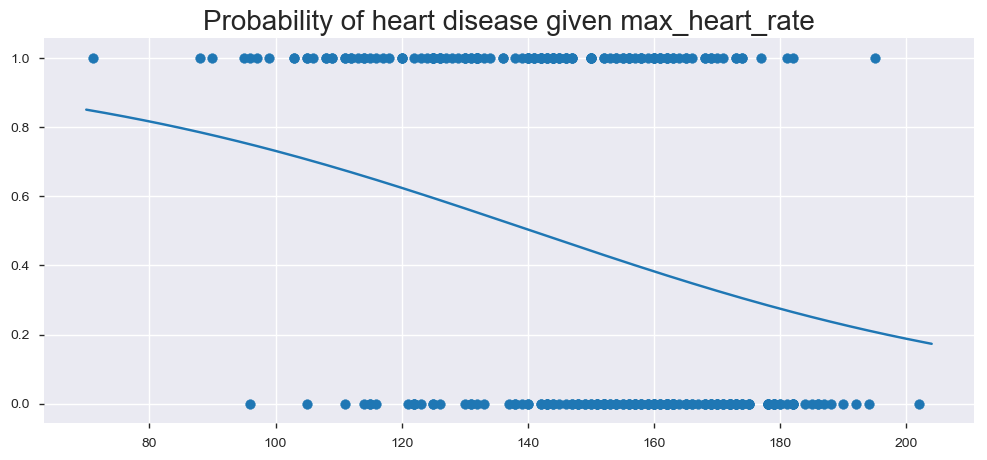

In [101]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(inputs, probs[:, 1]) 
#probs[:, 1] is second column of prob matrix of, prob of having heart disease
ax.set_title('Probability of heart disease given max_heart_rate', fontsize=20);
ax.scatter(X, y)

# Compute the exact model on our own

![][1]

[1]: images/logr_formula.png

In [102]:
def compute_probs(x):
    x1 = logr.intercept_ + logr.coef_ * x
    return 1 / (1 + np.exp(-x1))

In [103]:
my_probs = compute_probs(inputs)
my_probs[:5]

array([[0.85119492],
       [0.84804084],
       [0.84483208],
       [0.84156823],
       [0.83824887]])

# Isn't logistic regression supposed to draw an S curve?
Yes, but there wasn't much signal with the feature we chose, so curve had a very shallow slope. If we gave a wider range of the x values, you would see S curve.

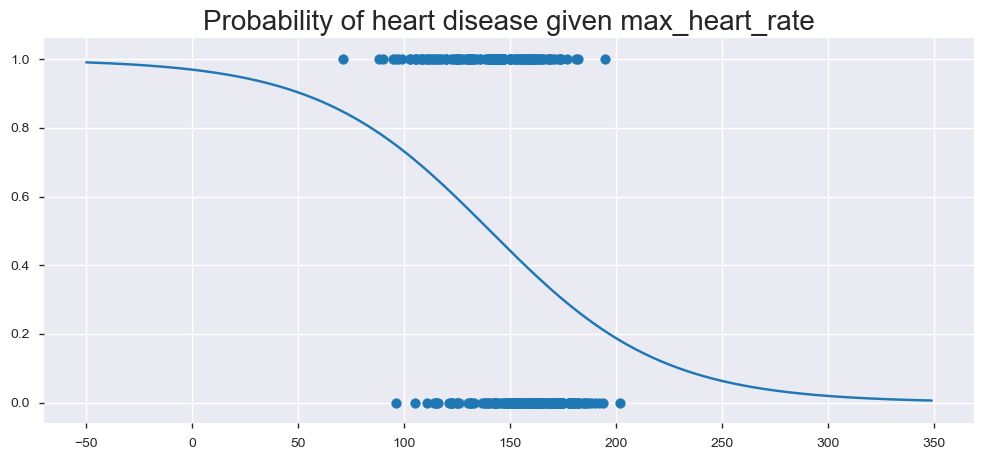

In [104]:
x = np.arange(-50, 350)
x = x.reshape(-1, 1)
probs = compute_probs(x)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, probs)
ax.set_title('Probability of heart disease given max_heart_rate', fontsize=20);
ax.scatter(X, y)

# Exercise
* Select another column to build and train a single-feature logistic regression model
* Make predictions
* Find your accuracy. Can you beat 66%?
* Draw the probability curve on the scatterplot
* Repeat for more columns

In [105]:
# your code here

In [106]:
X = heart['age'].values
y = heart['disease'].values

In [107]:
type(X)

numpy.ndarray

In [108]:
type(y)

numpy.ndarray

In [110]:
X[:5]

array([63, 67, 67, 37, 41])

In [111]:
X = X.reshape(-1, 1) # force the dimension to reshape to 2-d, 
# put new # of rows and new # of columns: ex X.reshape(101,3)
X[:5]

array([[63],
       [67],
       [67],
       [37],
       [41]])

In [112]:
logr2 = LogisticRegression()

In [113]:
logr2.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [114]:
X.min(), X.max()

(29, 77)

In [119]:
X_test = np.array([45, 40, 70])
X_test = X_test.reshape(-1, 1) 

In [120]:
logr2.predict(X_test)

array([0, 0, 1])

In [121]:
logr2.predict(X)

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,

In [124]:
probs2 = logr2.predict_proba(X_test)
probs2

array([[0.61168419, 0.38831581],
       [0.65005418, 0.34994582],
       [0.40854006, 0.59145994]])

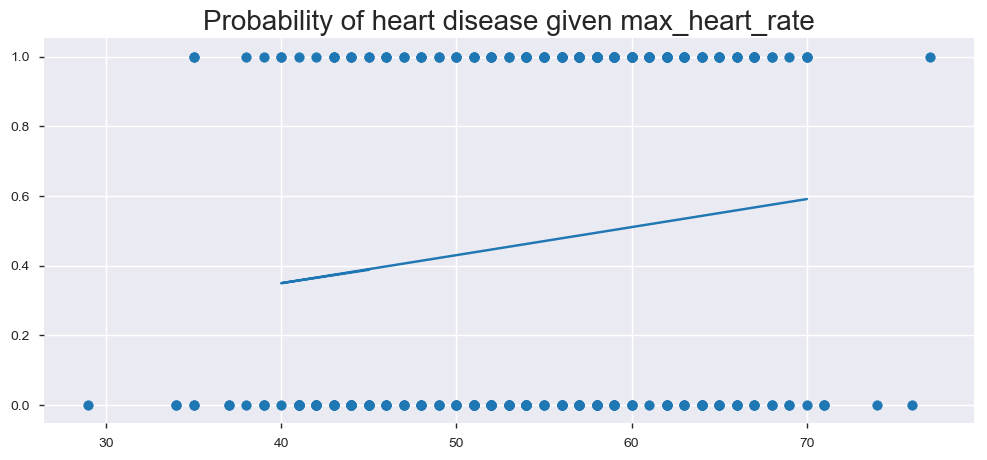

In [126]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(X_test, probs2[:, 1]) 
ax.set_title('Probability of age given max_heart_rate', fontsize=20);
ax.scatter(X, y)

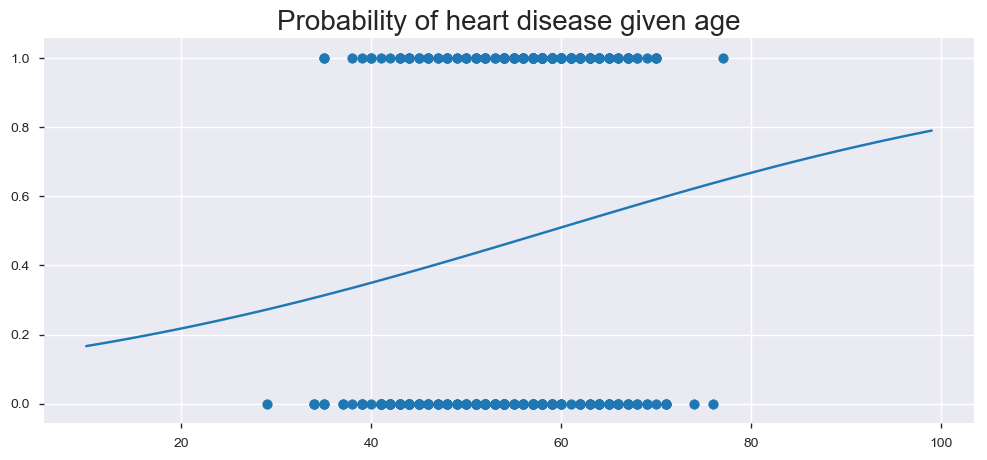

In [133]:
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(10, 100)
x = x.reshape(-1, 1)
probs2 = logr2.predict_proba(x)

ax.plot(x, probs2[:,1])
ax.set_title('Probability of heart disease given age', fontsize=20);
ax.scatter(X, y)